In [1]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained_densenet169
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.models as models
import pickle
import lime


### Pre-processing

In [2]:
class_names = ['Pleural Effusion']
policies = ['ones', 'zeroes', 'mixed']
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# Import the validation dataset as final test set
test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)




### Extraction of ground truth samples (4 images)

In [3]:
ground_truth_df = pd.read_excel("/Users/nikitaksnv/Desktop/XAI_projectt/ExplainableAIRadiology/ground_truth_data/bbox320x320.xlsx")
ground_truth_df.head()

Image   x_start  y_start   x_end   y_end  x_start.1  y_start .1  x_end .1  \
0   Test        48       160     144    288        NaN         NaN       NaN   
1  Rad_1       176       128     288    256        NaN         NaN       NaN   
2   Rad_2       32       128     144    256        NaN         NaN       NaN   
3  Rad_3        32       144     144    288      176.0       144.0     288.0   
4  Rad_5        32       160     144    240        NaN         NaN       NaN   

   y_end.1  
0      NaN  
1      NaN  
2      NaN  
3    272.0  
4      NaN

In [4]:
from PIL import Image
import numpy as np

# Open an image file
image = Image.open("ground_truth_images/Rad_1.png")
image_array = np.array(image)
image_array.shape

(320, 320)

In [5]:
ground_truth_df = ground_truth_df[ground_truth_df['Image '] != 'Test ']

In [6]:
ground_truth_df

Image   x_start  y_start   x_end   y_end  x_start.1  y_start .1  x_end .1  \
1  Rad_1       176       128     288    256        NaN         NaN       NaN   
2   Rad_2       32       128     144    256        NaN         NaN       NaN   
3  Rad_3        32       144     144    288      176.0       144.0     288.0   
4  Rad_5        32       160     144    240        NaN         NaN       NaN   

   y_end.1  
1      NaN  
2      NaN  
3    272.0  
4      NaN

In [7]:
images_paths = []
attributes_list = []

for row, column in ground_truth_df.iterrows():
    if column['Image '] != "Test ":
        path = f"ground_truth_images/{column['Image '].strip()}.png"
        images_paths.append(path)
        attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']])
        
labels = np.array([1, 1, 1, 1])



In [8]:
ground_truth_images_df = pd.DataFrame({"path": images_paths, "label": labels})
ground_truth_images_df.head()

path  label
0  ground_truth_images/Rad_1.png      1
1  ground_truth_images/Rad_2.png      1
2  ground_truth_images/Rad_3.png      1
3  ground_truth_images/Rad_5.png      1

#### Uploading the model we trained

In [9]:
densenet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
model_densenet169 = upload_pretrained_densenet169(densenet169, add_layers=True, n_labels=len(class_names), freeze_layers=True)
state_dict = torch.load("finetuned_models/densenet169.pth", map_location=torch.device('cpu'))



#### DataLoader object

In [10]:
test_dataset = CheXpertDataset(test_df, class_names, transform=transform, zip_path=None)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Evaluation of the model

In [11]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    # model.to(device)
    # model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)
            
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert pre`dictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

#### Evaluating the model (densenet121)

In [12]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(densenet169, test_loader, criterion)

Evaluating: 100%|██████████| 13/13 [00:34<00:00,  2.69s/batch]

Test Loss: 0.6829, Test Accuracy: 0.6634


In [13]:
#Here we turn test loader into generator so that we could extract images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [14]:
#Since batch=16 we extract 16 labels and corresponding images
print(f"images shape: {images.shape} | labels shape: {labels.shape}")


images shape: torch.Size([16, 3, 224, 224]) | labels shape: torch.Size([16, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

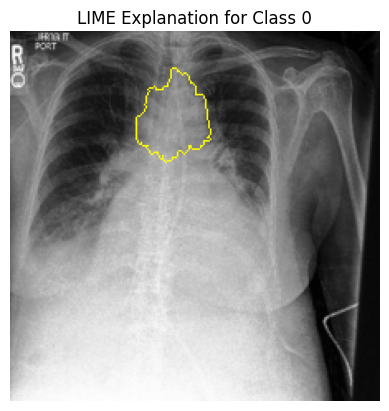

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from PIL import Image

# Ensure your model is in evaluation mode and on the proper device.
densenet169.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet169.to(device)


def denormalize2numpy(img_tensor):
    # Unnormalize the image: original = normalized * std + mean
    # Since mean=0.5 and std=0.5 for grayscale images:
    unnormalized = img_tensor * 0.5 + 0.5  #torch.Size([3, 224, 224])
    # Convert tensor from (C, H, W) to (H, W, C)
    img_np = unnormalized.permute(1, 2, 0).cpu().numpy() #(224, 224, 3)
    return img_np

# Assuming you have obtained an image from your testloader:
# For example, grabbing the first image from a batch:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[5]  # select the first image from the batch
img_np = denormalize2numpy(img)

# Prediction function for LIME:
def predict_fn(images):
    """
    images: list/array of images in NumPy format (H x W x C), with pixel values in [0, 1].
    Returns: a NumPy array of shape (n_samples, 2) with class probabilities.
    """
    # Convert each LIME image (numpy array) to a PIL image, then to a tensor.
    tensor_images = [
        transforms.ToTensor()(Image.fromarray((img * 255).astype(np.uint8)))
        for img in images
    ]
    # Stack into a single batch tensor of shape (N, C, H, W)
    batch = torch.stack(tensor_images).to(device)
    
    with torch.no_grad():
        outputs = densenet169(batch)  # outputs shape: (batch, 1)
        # Apply sigmoid to get probability for class 1.
        probs_class1 = torch.sigmoid(outputs)
        # Create two-class probabilities: class0 = 1 - p, class1 = p.
        probs = torch.cat([1 - probs_class1, probs_class1], dim=1)
        # print(probs)
    
    return probs.cpu().numpy()

# Create LIME image explainer.
explainer = LimeImageExplainer()

# Explain the prediction for the chosen image.
# For binary classification, we can set top_labels=2.
explanation = explainer.explain_instance(
    img_np,   
    predict_fn,
    top_labels=2,              # With binary classification, there are two labels.
    hide_color=0,
    num_samples=1000           # Number of perturbed samples
)

# Choose the label you wish to explain. For example, to explain class 1 (positive class):
label_to_explain = 0  # or use explanation.top_labels[0] if that suits your needs

# Get the explanation mask.
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=1,
    hide_rest=False
)

# Visualize the explanation.
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class {label_to_explain}")
plt.axis("off")
plt.show()


# ________________________________________________________________________________________________________________________________________________

### Gradcam based on paper: https://arxiv.org/abs/1610.02391
#### Library: https://github.com/jacobgil/pytorch-grad-cam

In [17]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer16.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer
                                                                            # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization
        
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay




#### GradCAM implementation for ground truth labels

In [19]:
ground_truth_images_df.columns

Index(['path', 'label'], dtype='object')

In [18]:
ground_truth_df.iloc[0]

Image         Rad_1 
x_start          176
y_start          128
x_end            288
y_end            256
x_start.1        NaN
y_start .1       NaN
x_end .1         NaN
y_end.1          NaN
Name: 1, dtype: object

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


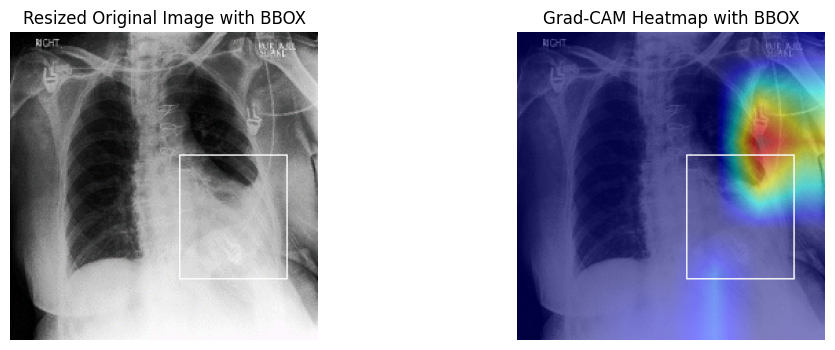

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


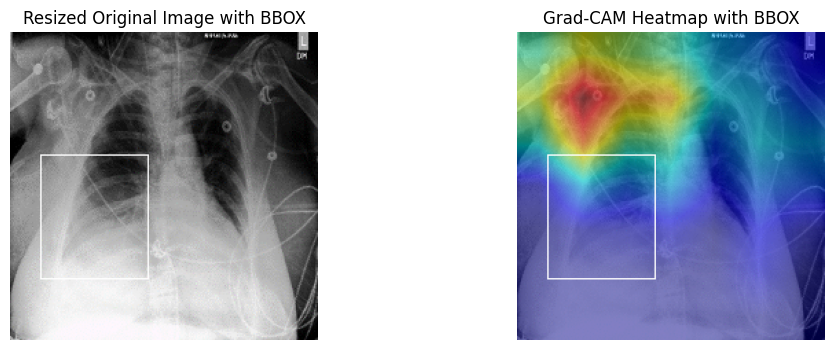

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


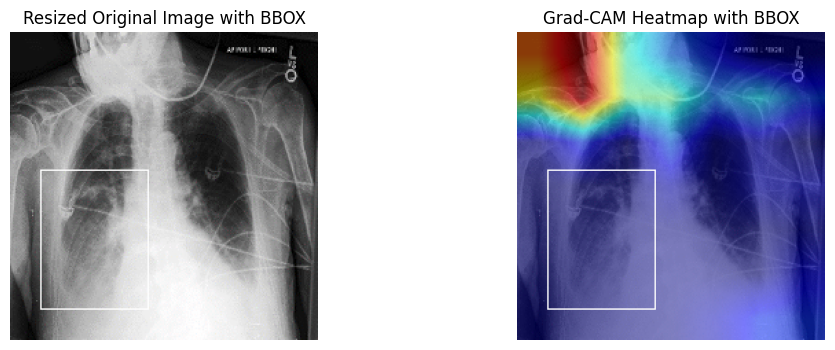

Actual label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


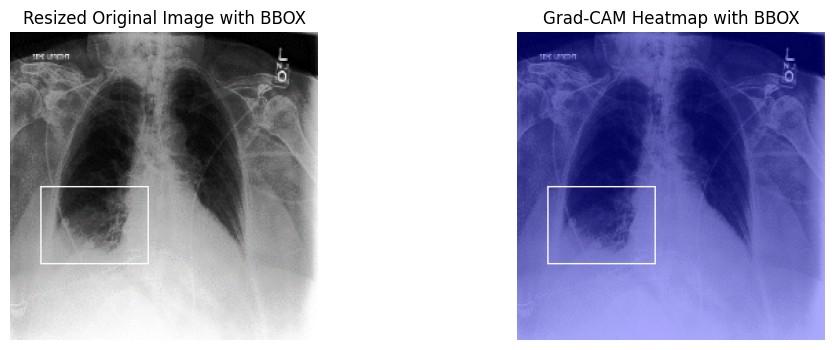

In [20]:
import cv2

for i in range(ground_truth_images_df.shape[0]):
    image_path = ground_truth_images_df.iloc[i]['path']
    actual_label = ground_truth_images_df.iloc[i]["label"]
    
    # Load BBOX coordinates
    x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_  = ground_truth_df.iloc[i][['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']]


    print(f"Actual label: {actual_label}")
    
    # Only process images with effusion (label == 1)
    if actual_label == 1:
        original_img, overlay = apply_gradcam(
            model=densenet169, 
            image_path=image_path, 
            transform=transform,
        )
        
        # Ensure BBOX coordinates are scaled to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)


        # HAndle none values
        # if not pd.notna(x_start_):
        #     print("NOT NONE")
        # else:
        #     print("None")


        

        # Draw BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)

        # Draw BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()

        cv2.rectangle(overlay_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)
        
        # Display Images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")

        plt.show()


#### Test dataframe

actual label 1


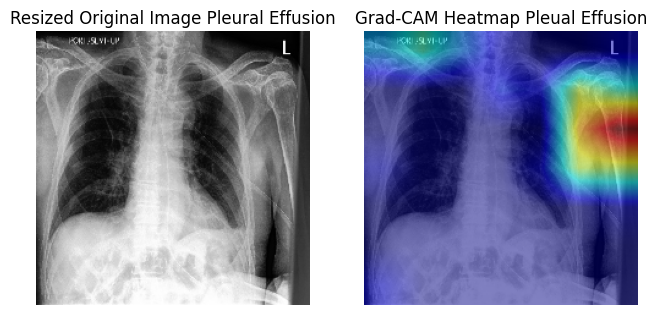

actual label 1


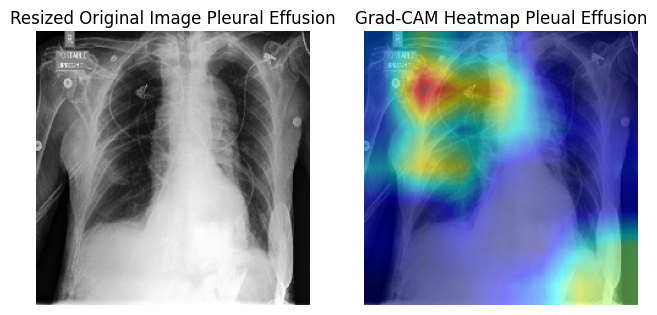

actual label 1


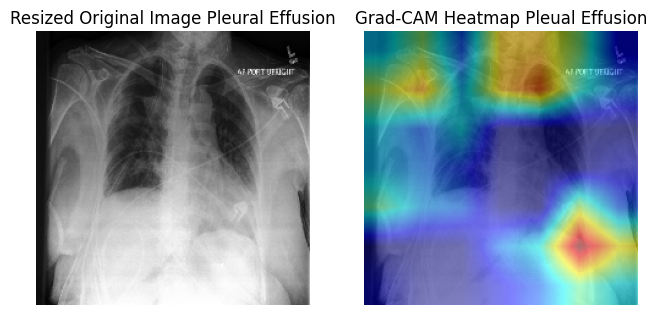

actual label 1


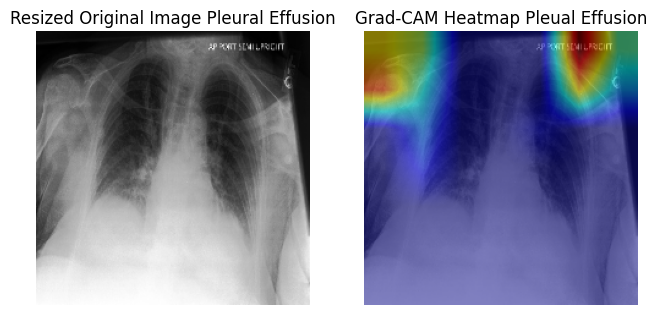

actual label 1


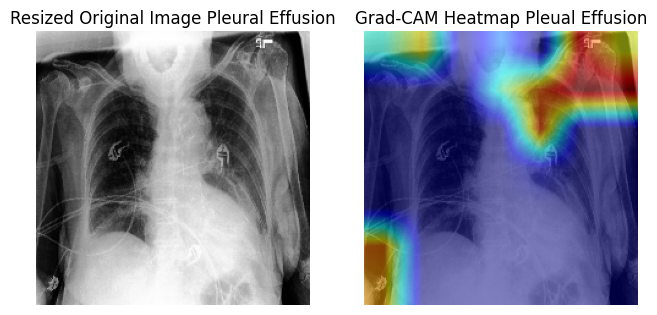

actual label 1


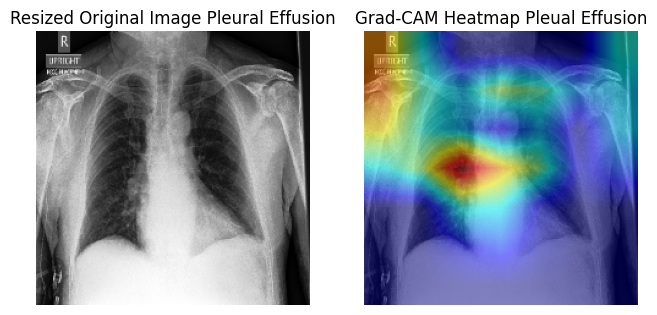

actual label 1


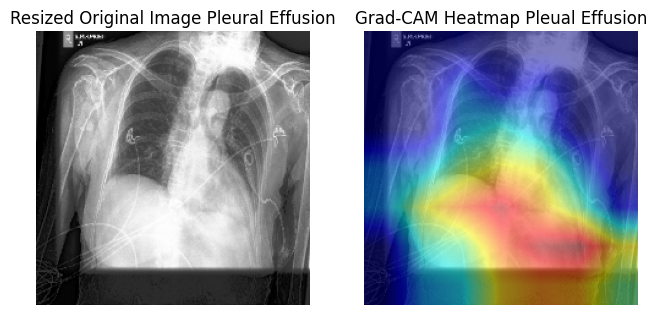

actual label 1


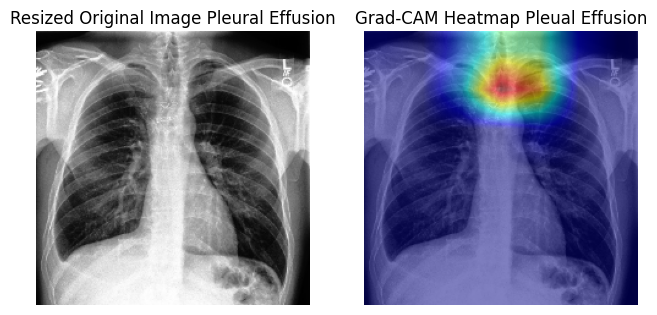

actual label 1


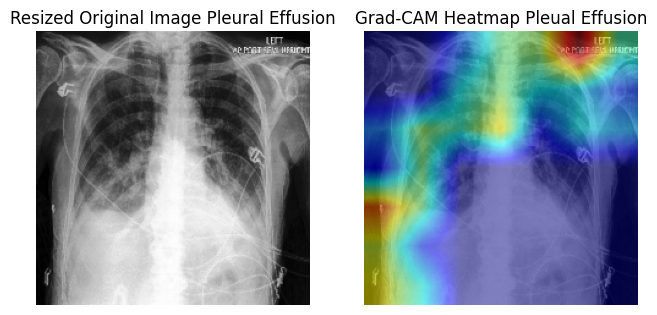

actual label 1


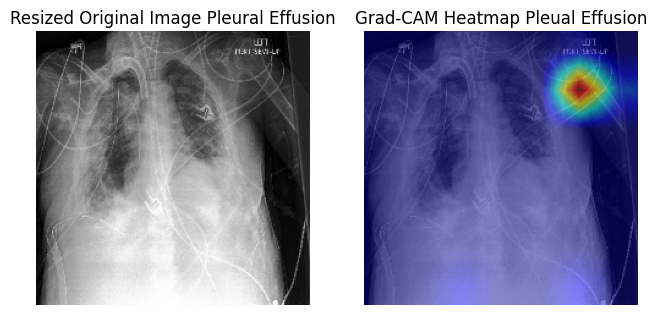

actual label 1


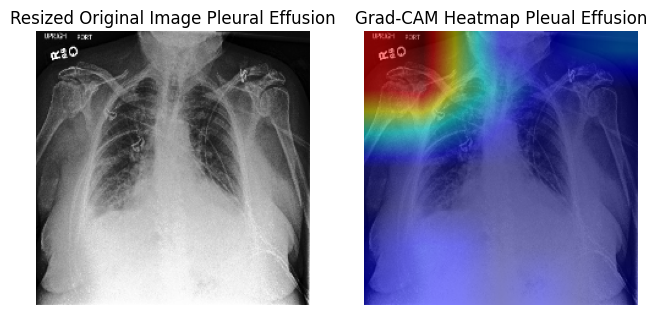

actual label 1


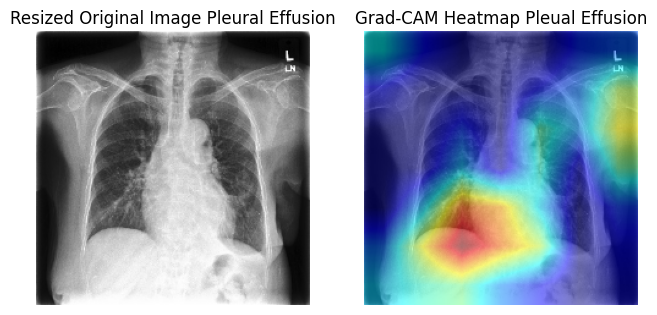

actual label 1


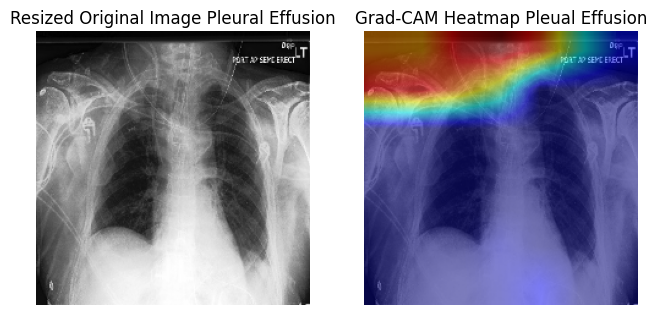

actual label 1


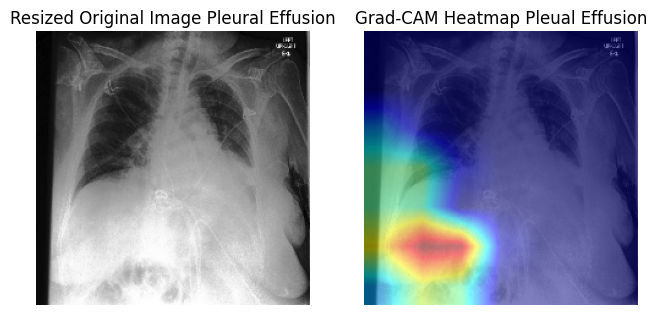

actual label 1


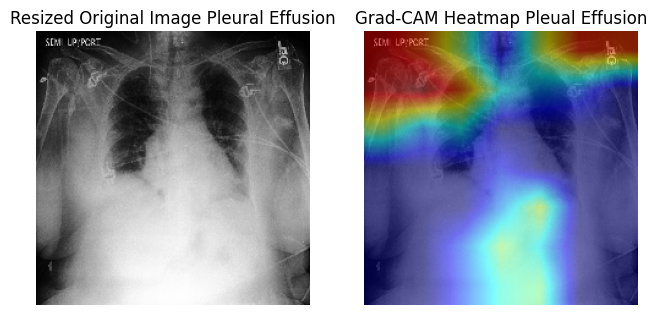

actual label 1


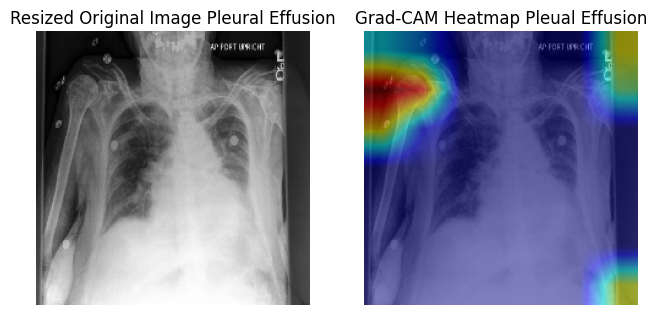

In [21]:
test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

for i in range(13, 60, 3):
    image_path = test_df_filtered.iloc[i]['path']
    actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]  

    print(f"actual label {actual_label}")
    # Only process images with effusion (label==1)
    if actual_label == 1:
        original_img, overlay = apply_gradcam(
            model=densenet169, 
            image_path=image_path, 
            transform=transform,
        )
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title("Resized Original Image Pleural Effusion")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(overlay)
        plt.title("Grad-CAM Heatmap Pleual Effusion")
        plt.axis("off")
        
        
        plt.show()


#### Let us extract activations (embeddings) from feature layer in densenet121 

#### In this example, we do it based on ground_truth_images_df

https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging#the-forward-hook-for-visualising-activations

In [24]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.activations = dict() # here we store activations per sample and then .clear() it
        
    def hook_fn(self, module, input, output):
        self.activations['output'] = output  # Store feature map
        
    def get_embeddings(self, image_paths, transform):
        embeddings = [] 
        
        # Register hook
        hook_handle = self.model.features.register_forward_hook(self.hook_fn)
        
        with torch.no_grad():  # Prevents tracking gradients
            for idx, path in enumerate(image_paths):
                # Load and preprocess image
                image = Image.open(path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

                # Clear previous activations
                self.activations.clear()
                
                # Forward pass
                _ = self.model(image_tensor)
                
                # Retrieve hooked feature maps
                features = self.activations['output']
                
                # Apply ReLU activation
                features = F.relu(features, inplace=True)
                
                # Global average pooling
                pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
                
                # Flatten into a 1D vector
                embedding = torch.flatten(pooled_features, 1)
                
                # Append to list after detaching from computation graph
                embeddings.append(embedding.detach().cpu())
                
                print(f"Processed image {idx+1}, embedding shape: {embedding.shape}")
        
        # Remove hook
        hook_handle.remove()
        
        return torch.cat(embeddings, dim=0)  # Combine all embeddings into one tensor




#### Let us extract test images we test upon

In [26]:
import os
folder = "ranking_annotations" 

ranking_image_paths = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("Rad")] 

testing_image_path = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("test")] 

# Create feature extractor
extractor = FeatureExtractor(densenet169)

# Extract embeddings
embeddings_torank = extractor.get_embeddings(image_paths=ranking_image_paths, transform=transform)
embeddings_test = extractor.get_embeddings(image_paths=testing_image_path, transform=transform)



Processed image 1, embedding shape: torch.Size([1, 1664])
Processed image 2, embedding shape: torch.Size([1, 1664])
Processed image 3, embedding shape: torch.Size([1, 1664])
Processed image 4, embedding shape: torch.Size([1, 1664])
Processed image 5, embedding shape: torch.Size([1, 1664])
Processed image 6, embedding shape: torch.Size([1, 1664])
Processed image 7, embedding shape: torch.Size([1, 1664])
Processed image 8, embedding shape: torch.Size([1, 1664])
Processed image 9, embedding shape: torch.Size([1, 1664])
Processed image 10, embedding shape: torch.Size([1, 1664])
Processed image 1, embedding shape: torch.Size([1, 1664])


In [35]:
embeddings_test.shape

torch.Size([1, 1664])

In [34]:
embeddings_torank[0].unsqueeze(0).shape

torch.Size([1, 1664])

In [36]:
ranking_dict = dict()
for idx, embedding_torank in enumerate(embeddings_torank):
    similarity_score = F.cosine_similarity(embedding_torank, embeddings_test)  
    print(f"Image path: {ranking_image_paths[idx]}, Similarity {float(similarity_score)}")
    ranking_dict[ranking_image_paths[idx]] = float(similarity_score)



Image path: ranking_annotations/Rad_8.png, Similarity 0.7493870854377747
Image path: ranking_annotations/Rad_9.png, Similarity 0.7624094486236572
Image path: ranking_annotations/Rad_10.png, Similarity 0.7465142011642456
Image path: ranking_annotations/Rad_1.png, Similarity 0.7904617786407471
Image path: ranking_annotations/Rad_2.png, Similarity 0.7508723735809326
Image path: ranking_annotations/Rad_3.png, Similarity 0.7516713738441467
Image path: ranking_annotations/Rad_7.png, Similarity 0.712059736251831
Image path: ranking_annotations/Rad_6.png, Similarity 0.7544617652893066
Image path: ranking_annotations/Rad_4.png, Similarity 0.7447071671485901
Image path: ranking_annotations/Rad_5.png, Similarity 0.7278426885604858


In [37]:
sorted_ranking_dict = sorted(ranking_dict.items(), key=lambda x: x[1], reverse=True)

In [57]:
sorted_ranking_dict

[('ranking_annotations/Rad_1.png', 0.7904617786407471),
 ('ranking_annotations/Rad_9.png', 0.7624094486236572),
 ('ranking_annotations/Rad_6.png', 0.7544617652893066),
 ('ranking_annotations/Rad_3.png', 0.7516713738441467),
 ('ranking_annotations/Rad_2.png', 0.7508723735809326),
 ('ranking_annotations/Rad_8.png', 0.7493870854377747),
 ('ranking_annotations/Rad_10.png', 0.7465142011642456),
 ('ranking_annotations/Rad_4.png', 0.7447071671485901),
 ('ranking_annotations/Rad_5.png', 0.7278426885604858),
 ('ranking_annotations/Rad_7.png', 0.712059736251831)]

#### GradCAM for the test image

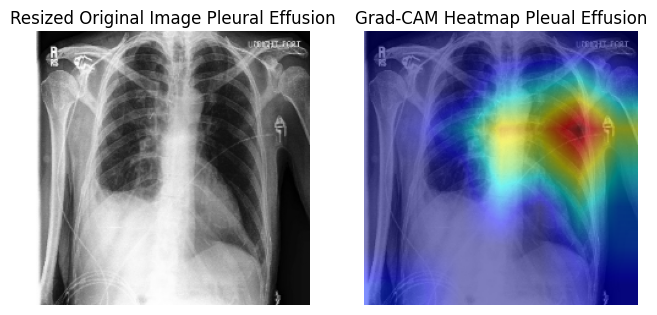

In [56]:
test_image_path = 'ranking_annotations/test_image.png'
original_img, overlay = apply_gradcam(
        model=densenet169, 
        image_path=test_image_path, 
        transform=transform,
    )


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Resized Original Image Pleural Effusion")
plt.axis("off")
    
plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap Pleual Effusion")
plt.axis("off")


plt.show()




#### GradCAM for ranked images

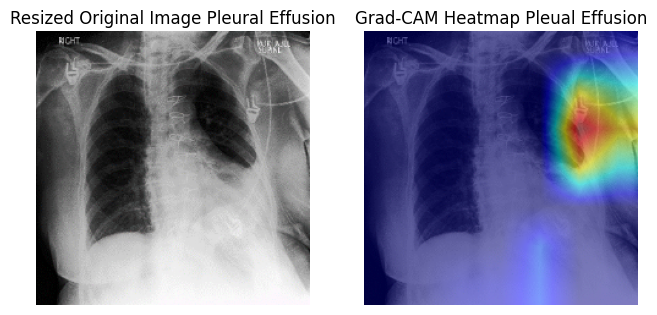

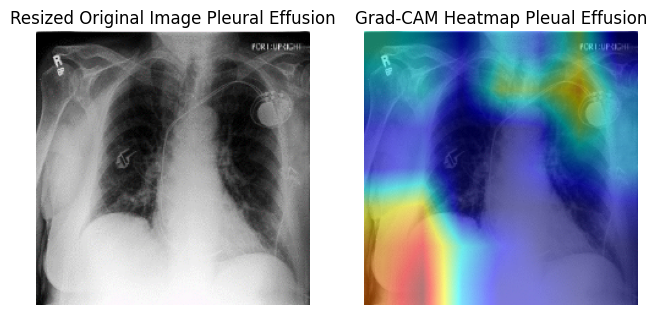

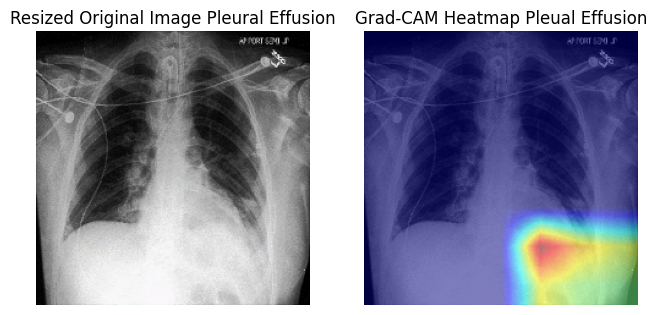

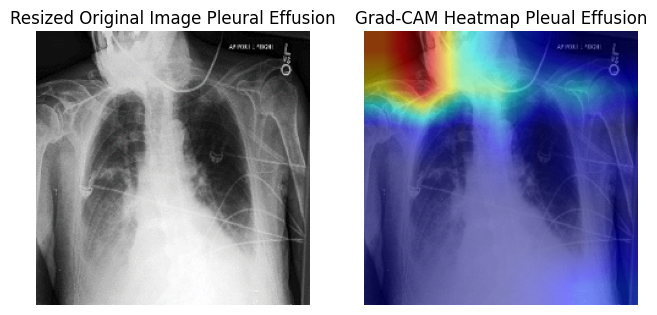

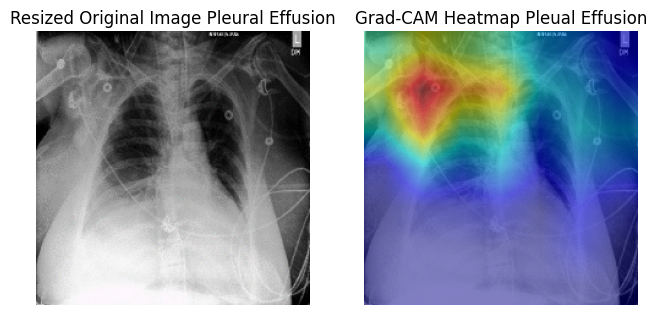

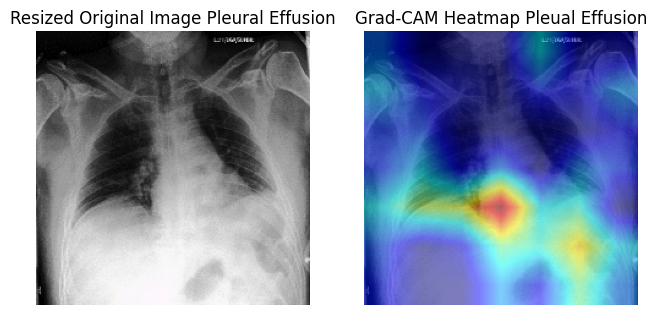

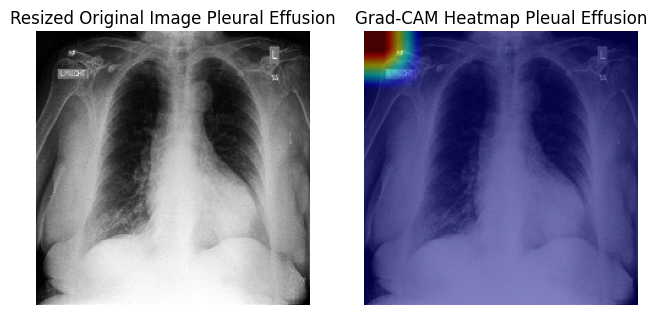

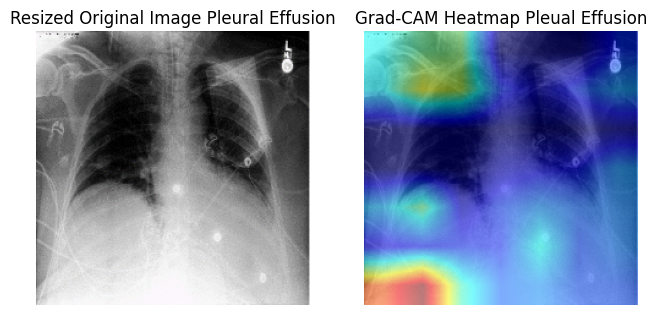

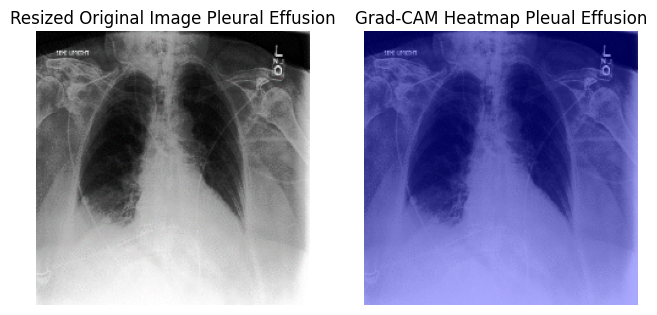

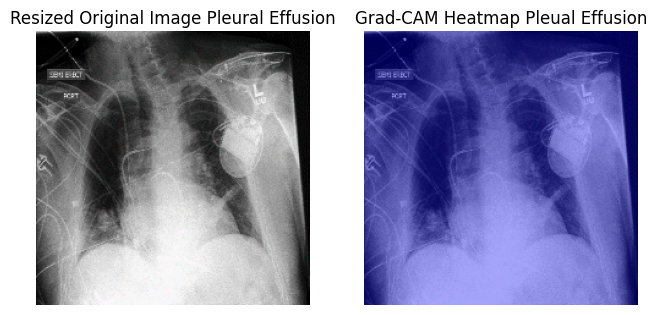

In [ ]:
for i in range(len(sorted_ranking_dict)):

    image_path = sorted_ranking_dict[i][0]
    
    original_img, overlay = apply_gradcam(
            model=densenet169, 
            image_path=image_path, 
            transform=transform,
        )
    

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")
        
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")
    
    
    plt.show()